# Build Neural Network

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from keras import Sequential
from keras.layers import Dense

import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('bankloan.txt')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
df = df.dropna()
df.isna().any()

Loan_ID              False
Gender               False
Married              False
Dependents           False
Education            False
Self_Employed        False
ApplicantIncome      False
CoapplicantIncome    False
LoanAmount           False
Loan_Amount_Term     False
Credit_History       False
Property_Area        False
Loan_Status          False
dtype: bool

In [5]:
df = df.drop('Loan_ID', axis = 1)

In [6]:
df.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y


In [7]:
df['LoanAmount'] = (df['LoanAmount']*1000).astype(int)
Counter(df['Loan_Status'])
#Counter(df['Loan_Status'])['Y']/df['Loan_Status'].size

Counter({'N': 148, 'Y': 332})

In [8]:
df.dtypes

Gender                object
Married               object
Dependents           float64
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount             int32
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [9]:
pre_y = df['Loan_Status']
pre_x = df.drop('Loan_Status', axis = 1)
dm_x = pd.get_dummies(pre_x)
dm_y = pre_y.map(dict(Y=1, N=0))
pre_x.head(3)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128000,360.0,1.0,Rural
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66000,360.0,1.0,Urban
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120000,360.0,1.0,Urban


In [10]:
dm_x.head(20)
test = dm_x.head(20).to_csv('test.csv', index=False)

In [11]:
smote = SMOTE(sampling_strategy= 'minority')
x1,y = smote.fit_resample(dm_x, dm_y)
sc = MinMaxScaler()
x = sc.fit_transform(x1)

In [12]:
Counter(y)

Counter({0: 332, 1: 332})

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                test_size=0.2,
                                                random_state=42,
                                                shuffle=True)

In [14]:
classifier = Sequential()
classifier.add(Dense(200, activation='relu',kernel_initializer='random_normal',input_dim=x_test.shape[1]))
classifier.add(Dense(400, activation='relu',kernel_initializer='random_normal'))
classifier.add(Dense(5, activation='relu',kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid',kernel_initializer='random_normal'))
classifier.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])
classifier.fit(x_train,y_train,epochs=50,batch_size=20, verbose=0)
eval_model = classifier.evaluate(x_train,y_train)
eval_model

17/17 [==============================] - 0s 2ms/step - loss: 0.2431 - accuracy: 0.9096


[0.24310946464538574, 0.909604549407959]

In [15]:
y_pred = classifier.predict(x_test)
y_pred = (y_pred>0.50)

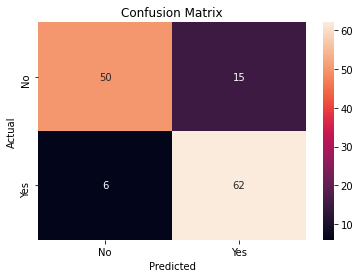

In [16]:
cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted');ax.set_ylabel('Actual');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['No','Yes']); ax.yaxis.set_ticklabels(['No','Yes']);

# Pickel the Model

In [17]:
# serialize model to JSON
model_json = classifier.to_json()
with open("classifier.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
classifier.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [18]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=3,
                       shuffle=True,
                       random_state=0)
cvscores = []
for train, test in kfold.split(x,y):
    #create model
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=17))
    model.add(Dense(400, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    #compile model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    #fit the model
    model.fit(x[train],y[train],epochs=100,verbose=0)
    
    #evaluate the model
    scores = model.evaluate(x[test],y[test],verbose=0)
    
    print("%s: %.2f%%" % (model.metrics_names[1],scores[1]*100))
    cvscores.append(scores[1]*100)
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

accuracy: 81.53%
accuracy: 82.35%
accuracy: 71.49%
78.46% (+/- 4.94%)
